In [1]:
library(ggplot2)
library(data.table)
library(dplyr)
library(tidyr)
library(purrr) 
library(patchwork)
library(scales)
if (!require(extrafont)) install.packages("extrafont")
library(extrafont)

# 3. 폰트 로드
loadfonts()

Warning message:
“패키지 ‘ggplot2’는 R 버전 4.3.3에서 작성되었습니다”
Warning message:
“패키지 ‘dplyr’는 R 버전 4.3.3에서 작성되었습니다”

다음의 패키지를 부착합니다: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“패키지 ‘tidyr’는 R 버전 4.3.3에서 작성되었습니다”
Warning message:
“패키지 ‘purrr’는 R 버전 4.3.3에서 작성되었습니다”

다음의 패키지를 부착합니다: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Warning message:
“패키지 ‘patchwork’는 R 버전 4.3.3에서 작성되었습니다”
Warning message:
“패키지 ‘scales’는 R 버전 4.3.3에서 작성되었습니다”

다음의 패키지를 부착합니다: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


필요한 패키지를 로딩중입니다: extrafont

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“‘extrafont’이라고 불리는 패키지가 없습니다”
‘extrafontdb’, ‘Rttf2pt1’(들)을

In [2]:
cohort <- "simulation" # UKB, GS

# Step 1. Load data

## Load slope test results

In [3]:
# 방법 1: paste0() 사용
frreg_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/", 
    cohort, 
    "/obj1/slope-test"
)

# .slope 파일 리스트 불러오기
files_list <- list.files(
    path = frreg_path, 
    pattern = "\\.slope$",  
    full.names = TRUE
) %>% 
    # .raw.slope 파일 제외
    .[!grepl("\\.raw\\.slope$", .)]

length(files_list)

[1] 7290

In [4]:
# 모든 .slope 파일 읽고 원하는 형태로 가공하기
df_slope_test <- files_list %>%
    # 각 파일을 읽어서 리스트로 만들기
    map(function(file) {
        # 파일명에서 pheno 이름 추출 (첫번째 '.' 이전까지의 문자열)
        pheno <- basename(file) %>%
            strsplit("\\.") %>%
            .[[1]] %>%
            .[1]
        
        # 파일 읽기
        df <- fread(file)
        
        # slope와 intercept의 median 값 추출
        slope_val <- df[param == "slope", median]
        intercept_val <- df[param == "intercept", median]
        
        # significant 판단
        slope_lower <- df[param == "slope", `lower(2.5%)`]
        slope_upper <- df[param == "slope", `upper(97.5%)`]
        
        significant <- case_when(
            slope_lower > 1 ~ "fast",
            slope_upper < 1 ~ "slow",
            TRUE ~ "similar"
        )
        
        # 데이터프레임 생성
        data.frame(
            pheno = pheno,
            slope = slope_val,
            intercept = intercept_val,
            significant = significant
        )
    }) %>%
    # 모든 데이터프레임 합치기
    bind_rows()

head(df_slope_test)

,pheno,slope,intercept,significant
,<chr>,<dbl>,<dbl>,<chr>
1,G_140-S_109-w_1152-e_10,0.4376302,-2.035210,slow
2,G_140-S_109-w_1152-e_5,0.4231007,-2.063328,slow
3,G_140-S_109-w_1152-e_50,0.2971038,-2.241941,similar
4,G_140-S_109-w_1178-e_10,0.4517030,-2.032238,slow
5,G_140-S_109-w_1178-e_5,0.4390127,-2.054435,slow
6,G_140-S_109-w_1178-e_50,0.4607094,-1.989773,similar


## Load prediction results

In [5]:
frreg_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/", 
    cohort, 
    "/obj1/prediction"
)

# .slope 파일 리스트 불러오기
files_list <- list.files(
    path = frreg_path, 
    pattern = "\\.pred$",  
    full.names = TRUE
) %>% 
    # .raw.slope 파일 제외
    .[!grepl("\\.raw\\.pred$", .)]

length(files_list)

[1] 7290

In [6]:
# 모든 .pred 파일 읽고 원하는 형태로 가공하기
df_prediction <- files_list %>%
    # 각 파일을 읽어서 리스트로 만들기
    map(function(file) {
        # 파일명에서 pheno 이름 추출 (첫번째 '.' 이전까지의 문자열)
        pheno <- basename(file) %>%
            strsplit("\\.") %>%
            .[[1]] %>%
            .[1]
        
        # 파일 읽기
        df <- fread(file)
        
        # 필요한 파라미터만 추출 (V(g), V(s), w)
        df_filtered <- df %>%
            filter(param %in% c("V(g)", "V(s)", "w"))
        
        # wide format으로 변환
        data.frame(
            pheno = pheno,
            # V(g) 관련 컬럼
            Vg_median = df_filtered[param == "V(g)", median],
            Vg_lower = df_filtered[param == "V(g)", `lower(2.5%)`],
            Vg_upper = df_filtered[param == "V(g)", `upper(97.5%)`],
            # V(s) 관련 컬럼
            Vs_median = df_filtered[param == "V(s)", median],
            Vs_lower = df_filtered[param == "V(s)", `lower(2.5%)`],
            Vs_upper = df_filtered[param == "V(s)", `upper(97.5%)`],
            # w 관련 컬럼
            w_median = df_filtered[param == "w", median],
            w_lower = df_filtered[param == "w", `lower(2.5%)`],
            w_upper = df_filtered[param == "w", `upper(97.5%)`]
        )
    }) %>%
    # 모든 데이터프레임 합치기
    bind_rows()

head(df_prediction)

In [7]:
# merg
# df_slope_test와 df_prediction을 pheno 기준으로 병합
df_merged <- df_slope_test %>%
    left_join(df_prediction, by = "pheno") %>% 
    drop_na()


get_true_significant <- function(pheno) {
    w_value <- as.numeric(gsub(".*w_(\\d+).*", "\\1", pheno)) / 1000
    case_when(
        w_value < 1 ~ "increasing",
        w_value >= 1 & w_value < 1.8 ~ "slow",
        w_value >= 1.8 & w_value <= 2.2 ~ "similar",
        w_value > 2.2 ~ "fast",
        TRUE ~ NA_character_    # 예외 케이스 처리
    )
}

df_merged <- df_merged %>%
    mutate(
        # 각 파라미터 값 추출 및 1000으로 나누기
        G = as.numeric(gsub(".*G_(\\d+).*", "\\1", pheno)) / 1000,
        S = as.numeric(gsub(".*S_(\\d+).*", "\\1", pheno)) / 1000,
        w = 1 / (as.numeric(gsub(".*w_(\\d+).*", "\\1", pheno)) / 1000),
        e = as.numeric(gsub(".*e_(\\d+).*", "\\1", pheno)) / 1000,
        # 기존 true_significant 계산
        true_significant = sapply(pheno, get_true_significant),
        match_result = true_significant == significant
    ) %>%
    mutate(
        true_significant = factor(true_significant, 
                                levels = c("fast", "slow", "increasing", "similar")),
        significant = factor(significant, 
                           levels = c("fast", "slow", "increasing", "similar"))
    ) %>%
    filter(!is.na(slope), 
           !is.na(intercept),
           !is.na(true_significant),
           !is.na(significant))

           
# 결과 확인
dim(df_merged)

[1] 7290   19

In [8]:
head(df_merged)

,pheno,slope,intercept,significant,Vg_median,Vg_lower,Vg_upper,Vs_median,Vs_lower,Vs_upper,w_median,w_lower,w_upper,G,S,w,e,true_significant,match_result
,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
1,G_140-S_109-w_1152-e_10,0.4376302,-2.035210,slow,0.1698524,1e-06,0.1913566,0.09543078,0.08556861,0.1842063,0.915,0.72475,0.95,0.14,0.109,0.8680556,0.010,slow,TRUE
2,G_140-S_109-w_1152-e_5,0.4231007,-2.063328,slow,0.1426957,1e-06,0.1893791,0.10856081,0.08617615,0.1802251,0.875,0.74000,0.95,0.14,0.109,0.8680556,0.005,slow,TRUE
3,G_140-S_109-w_1152-e_50,0.2971038,-2.241941,similar,0.0000010,1e-06,0.1814459,0.20160721,0.13153233,0.2095523,0.600,0.52425,0.60,0.14,0.109,0.8680556,0.050,slow,FALSE
4,G_140-S_109-w_1178-e_10,0.4517030,-2.032238,slow,0.1546970,1e-06,0.2011277,0.10205261,0.08022152,0.1842258,0.875,0.71000,0.95,0.14,0.109,0.8488964,0.010,slow,TRUE
5,G_140-S_109-w_1178-e_5,0.4390127,-2.054435,slow,0.1636612,1e-06,0.2031426,0.09856101,0.07966304,0.1802513,0.880,0.72475,0.95,0.14,0.109,0.8488964,0.005,slow,TRUE
6,G_140-S_109-w_1178-e_50,0.4607094,-1.989773,similar,0.0000010,1e-06,0.0000010,0.20018080,0.19633789,0.2058775,0.600,0.58475,0.60,0.14,0.109,0.8488964,0.050,slow,FALSE


# plot theme

In [9]:
# 공통 테마 함수 정의
get_nature_theme <- function() {
    theme_bw() +
        theme(
            # 전체적인 배경
            panel.background = element_rect(fill = "white", color = "black", size = 0.5),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            
            # 축 설정
            axis.line = element_line(color = "black", size = 0.3),
            axis.text = element_text(size = 6.5, color = "black"),
            axis.title = element_text(size = 7.5, color = "black"),
            axis.ticks = element_line(size = 0.3),
            axis.ticks.length = unit(0.8, "mm"),
            
            # 범례 설정
            legend.background = element_rect(fill = "transparent", color = NA),
            legend.text = element_text(size = 5),
            legend.title = element_text(size = 5),
            legend.key.size = unit(0.5, "lines"),
            legend.key.height = unit(0.6, "lines"),
            legend.key.width = unit(0.3, "lines"),
            legend.position = "right",
            legend.box = "vertical",
            legend.margin = margin(0, 0, 0, 0),
            legend.spacing.y = unit(0.1, "cm"),
            
            # 여백 설정
            plot.margin = unit(c(0.1, 0.2, 0.1, 0.1), "cm")
        )
}

# 공통 색상 정의
color_values <- c(
    "fast" = "#E64B35",
    "slow" = "#4DBBD5",
    "similar" = "#7E7E7E"
)

# Step 2. Plot

In [10]:
# for_plot <- df_merged %>%
#     filter(Vg_lower > 1e-4 & Vs_lower > 1e-4)

for_plot <- df_merged %>% 
    filter(true_significant != "increasing") %>% 
    filter(Vg_lower > 1e-4 & Vs_lower > 1e-4)

# for_plot <- df_merged %>%
    # filter(Vg_lower > 1e-4)

# 필터링 결과 확인
dim(for_plot)

[1] 1586   19

In [36]:
plot_parameter_comparison <- function(data) {
    color_values <- c(
        "fast" = "#E41A1C",    
        "slow" = "#377EB8",    
        "similar" = "#999999"
    )
    
    # G variance plot
    plot_g <- data %>% 
        mutate(G_category = factor(format(round(G, 3), nsmall = 3))) %>%
        ggplot(aes(x = G_category, y = Vg_median, color = significant)) +
        geom_boxplot(alpha = 0.6, outlier.size = 0.5) +  # boxplot을 먼저 그림
        geom_point(aes(x = G_category, y = as.numeric(as.character(G_category))), 
                  color = "black", size = 1, shape = 4) +  # reference point를 나중에 그림
        geom_line(aes(x = G_category, y = as.numeric(as.character(G_category)), group = 1), 
                  color = "black", linetype = "dashed", size = 0.3) +
        scale_color_manual(values = color_values) +
        facet_grid(. ~ e, labeller = labeller(e = function(x) parse(text = paste0("error == ", x)))) +
        labs(x = "True G. variance", y = "Estimated G. variance") +
        get_nature_theme() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

    # S variance plot
    plot_s <- data %>% 
        mutate(S_category = factor(format(round(S, 3), nsmall = 3))) %>%
        ggplot(aes(x = S_category, y = Vs_median, color = significant)) +
        geom_boxplot(alpha = 0.6, outlier.size = 0.5) +
        geom_point(aes(x = S_category, y = as.numeric(as.character(S_category))), 
                  color = "black", size = 1, shape = 4) +
        geom_line(aes(x = S_category, y = as.numeric(as.character(S_category)), group = 1), 
                  color = "black", linetype = "dashed", size = 0.3) +
        scale_color_manual(values = color_values) +
        facet_grid(. ~ e, labeller = labeller(e = function(x) parse(text = paste0("error == ", x)))) +
        labs(x = "True S. variance", y = "Estimated S. variance") +
        get_nature_theme() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

    # S decaying plot (소수점 둘째자리까지만)
    plot_w <- data %>% 
        mutate(w_category = factor(format(round(w, 2), nsmall = 2))) %>%  # 소수점 둘째자리로 변경
        ggplot(aes(x = w_category, y = w_median, color = significant)) +
        geom_boxplot(alpha = 0.6, outlier.size = 0.5) +
        geom_point(aes(x = w_category, y = as.numeric(as.character(w_category))), 
                  color = "black", size = 1, shape = 4) +
        geom_line(aes(x = w_category, y = as.numeric(as.character(w_category)), group = 1), 
                  color = "black", linetype = "dashed", size = 0.3) +
        scale_color_manual(values = color_values) +
        facet_grid(. ~ e, labeller = labeller(e = function(x) parse(text = paste0("error == ", x)))) +
        labs(x = "True 1/S. decaying", y = "Estimated 1/S. decaying") +
        get_nature_theme() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

    # 범례는 마지막 플롯에만 표시
    plot_g <- plot_g + theme(legend.position = "none")
    plot_s <- plot_s + theme(legend.position = "none")
    plot_w <- plot_w + 
        theme(
            legend.position = "right",
            legend.title = element_text(size = 9),
            legend.text = element_text(size = 8)
        )

    # 세 플롯을 수직으로 결합
    combined_plot <- plot_g / plot_s / plot_w +
        plot_layout(heights = c(1, 1, 1)) +
        plot_annotation(theme = theme(plot.margin = margin(5, 15, 5, 5)))

    return(combined_plot)
}

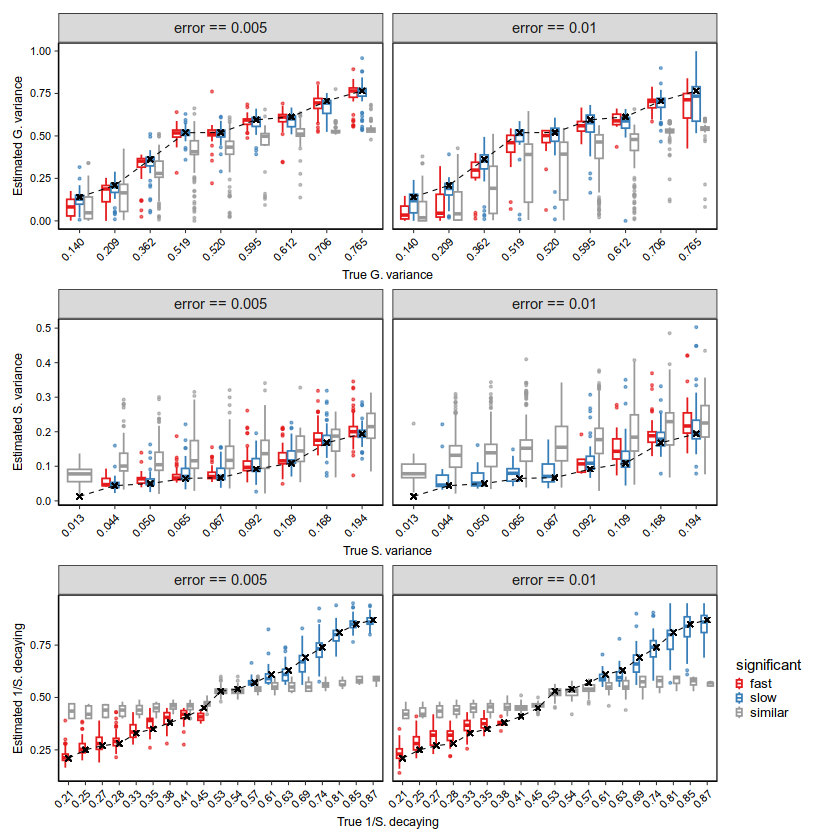

In [40]:
# 플롯 생성
for_plot <- df_merged %>% 
    filter(true_significant != "increasing") %>% 
    filter(e < 0.05) 

p <- plot_parameter_comparison(for_plot)
print(p)

# 파일 저장
output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
    "simulation.prediction.pdf"
)

ggsave(
# 플롯 생성 및 저장
    filename = output_path,
    plot = p,
    width = 178,
    height = 160,
    units = "mm",
    dpi = 300
)